In [1]:
import pandas as pd

dataset = pd.read_parquet("../dataset/train_math_exercice.parquet")
dataset

,problem,level,type,solution,id,source,category
0,Find the positive base $b$ in which the equati...,Level 4,Number Theory,When we rewrite the above equation with the ba...,number_theory_1004,test,4
1,There are eight boys and six girls who are mem...,Level 3,Counting & Probability,"First, we consider how many ways there are to ...",counting_and_probability_682,test,1
2,What is the domain of the function $g(x) = \fr...,Level 1,Intermediate Algebra,The formula for $g(x)$ has a defined value unl...,intermediate_algebra_1317,train,3
3,"A standard deck of 52 cards has 13 ranks (Ace,...",Level 3,Prealgebra,There are $3 \times 4 = 12$ face cards and 52 ...,prealgebra_1079,test,5
4,"The two endpoints of a segment are at $(1,4)$ ...",Level 1,Algebra,The midpoint of the segment is at $\left(\frac...,algebra_1025,test,0
...,...,...,...,...,...,...,...
9995,Given that 0.5 liters is approximately 1.05 pi...,Level 3,Prealgebra,"If half a liter is 1.05 pints, then a whole li...",prealgebra_532,train,5
9996,"In the figure shown, $AC=13$ and $DC=2$ units....",Level 4,Geometry,"Since $AC=AD+DC=13$ and $DC=2$, $AD=11$. We al...",geometry_953,test,2
9997,There are eight furlongs in a mile. There are ...,Level 4,Prealgebra,We have \[\n14\text{ days} = 1 \text{ fortnig...,prealgebra_1260,test,5
9998,"If a rectangular prism has a length of $l$, a ...",Level 2,Algebra,We are given that $$\sqrt{l^2 + w^2 + h^2} = \...,algebra_676,train,0


In [2]:
from sentence_transformers import SentenceTransformer

pretrained_model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v1", device='cuda')
pretrained_model.to('cuda')
pretrained_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [3]:
import numpy as np
from scipy.spatial.distance import cosine

def cosine_similarity(vec_a, vec_b) -> float:
        return 1 - cosine(
            np.array(vec_a).reshape(1, -1)[0],
            np.array(vec_b).reshape(1, -1)[0],
        )

def get_scores(dataset, embedding_column="sentence_embedding"):

    identical_category_scores = []
    different_category_scores = []

    for i, sample in dataset.iterrows():
        cat = sample['category']

        pos_example = dataset.loc[dataset['category']==cat].sample(n=1).iloc[0]
        identical_category_scores.append(cosine_similarity(sample[embedding_column], pos_example[embedding_column]))

        neg_example = dataset.loc[dataset['category']!=cat].sample(n=1).iloc[0]
        different_category_scores.append(cosine_similarity(sample[embedding_column], neg_example[embedding_column]))
        
    return identical_category_scores, different_category_scores

In [4]:
BATCH_SIZE = 32

dataset["pretrained_sentence_embedding"] = pd.Series(
        pretrained_model.encode(dataset["problem"], batch_size=BATCH_SIZE, device='cuda', show_progress_bar=True).tolist()
    )

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Jensen-Shannon distance:  0.21370481308628572
Wasserstein distance:  0.06940291771632053


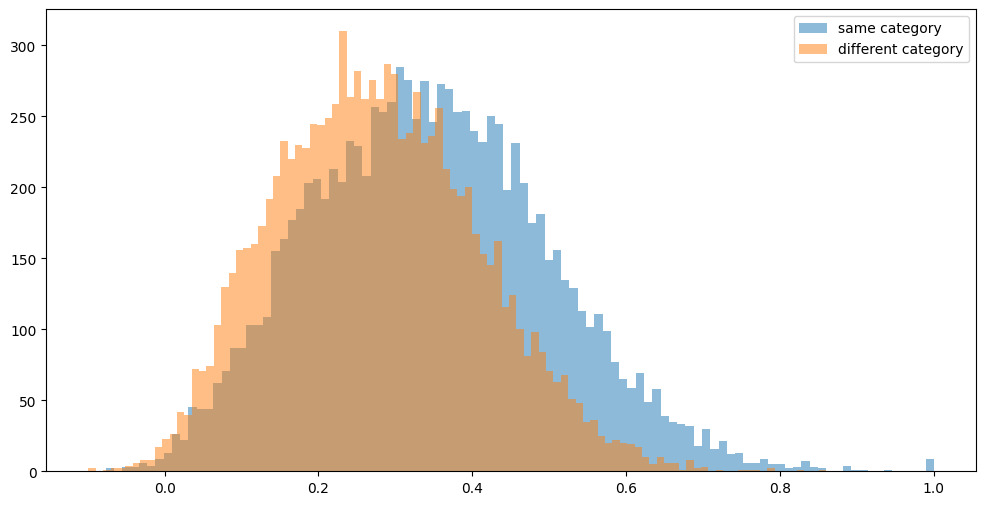

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import wasserstein_distance

identical_category_scores, different_category_scores = get_scores(dataset, "pretrained_sentence_embedding")

print("Jensen-Shannon distance: ", distance.jensenshannon(np.clip(identical_category_scores, 0.001, None), np.clip(different_category_scores, 0.001, None)))
print("Wasserstein distance: ", wasserstein_distance(identical_category_scores, different_category_scores))

plt.figure(figsize=(12, 6))
plt.hist(np.array(identical_category_scores), alpha=0.5, bins=100, label="same category")
plt.hist(np.array(different_category_scores), alpha=0.5, bins=100, label="different category")
plt.legend(loc='upper right')
plt.show()

In [6]:
import pickle

before_finetuning = {
    "identical_category_scores": identical_category_scores, 
    "different_category_scores":  different_category_scores
}

with open("before_finetuning.pkl", "wb") as fp:   #Pickling
    pickle.dump(before_finetuning, fp)
    
with open("before_finetuning.pkl", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [7]:
b.keys()

dict_keys(['identical_category_scores', 'different_category_scores'])

In [8]:
import torch
from sentence_transformers import SentenceTransformer, models

model = SentenceTransformer("../models/sbert-math-problem-ContrastiveLoss-cuda/", device='cpu')
model.to('cuda')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [9]:
BATCH_SIZE = 32

dataset["sentence_embedding"] = pd.Series(
        model.encode(dataset["problem"], batch_size=BATCH_SIZE, device='cuda', show_progress_bar=True).tolist()
    )

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import wasserstein_distance

identical_category_scores, different_category_scores = get_scores(dataset, "sentence_embedding")

print("Jensen-Shannon distance: ", distance.jensenshannon(np.clip(identical_category_scores, 0.001, None), np.clip(different_category_scores, 0.001, None)))
print("Wasserstein distance: ", wasserstein_distance(identical_category_scores, different_category_scores))

plt.figure(figsize=(12, 6))
plt.hist(np.array(identical_category_scores), alpha=0.5, bins=100, label="same category")
plt.hist(np.array(different_category_scores), alpha=0.5, bins=100, label="different category")
plt.legend(loc='upper right')
plt.show()

In [ ]:
import pickle

after_finetuning = {
    "identical_category_scores": identical_category_scores, 
    "different_category_scores":  different_category_scores
}

with open("after_finetuning.pkl", "wb") as fp:   #Pickling
    pickle.dump(after_finetuning, fp)
    
with open("after_finetuning.pkl", "rb") as fp:   # Unpickling
    b = pickle.load(fp)
    
b.keys()

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_top_matches(query: str, dataset: pd.DataFrame, model, threshold: float = 0.0):
    print("search dataset size: ", len(dataset))
    search_dataset = dataset.copy().reset_index(drop=True)
    query_embeds = model.encode(query)
    dataset_embeds = np.array(search_dataset["sentence_embedding"].tolist())
    search_dataset["score"] = pd.Series(cosine_similarity(query_embeds.reshape(1, -1), dataset_embeds)[0])
    search_dataset["rank"] = search_dataset["score"].rank(method='first', ascending=False)
    print("Search results: ")
    return search_dataset.loc[search_dataset["score"]>threshold].sort_values(["rank"], ascending=True).iloc[:10].reset_index(drop=True)

In [ ]:
#search engine
results = get_top_matches("exercice with circles and volumes", dataset, model)

In [ ]:
from IPython.display import display, Latex

for i, result in results.iterrows():
    print(i, result["score"])
    display(Latex('='*20+'METADATA'+'='*20))
    display(Latex("Type: "+ result['type']))
    display(Latex("Level: " + result['level']))
    display(Latex('='*20+'EXERCICE'+'='*20))
    display(Latex(result['problem']))
    display(Latex('='*20+'SOLUTION'+'='*20))
    display(Latex(result['solution']))
    print("\n")

In [ ]:
results = get_top_matches("exercice on probability", dataset, model)
from IPython.display import display, Latex

for i, result in results.iterrows():
    print(i, result["score"])
    display(Latex('='*20+'METADATA'+'='*20))
    display(Latex("Type: "+ result['type']))
    display(Latex("Level: " + result['level']))
    display(Latex("id: " + result['id']))
    display(Latex('='*20+'EXERCICE'+'='*20))
    display(Latex(result['problem']))
    display(Latex('='*20+'SOLUTION'+'='*20))
    display(Latex(result['solution']))
    print("\n")

In [ ]:
#recommend similar exercices

exercice = dataset.loc[dataset["id"]=="intermediate_algebra_1586"].iloc[0]["problem"]
display(Latex(exercice))

In [17]:
recs = get_top_matches(exercice, dataset, model)
for i, result in recs.iterrows():
    print(i, result["score"])
    display(Latex('='*20+'METADATA'+'='*20))
    display(Latex("Type: "+ result['type']))
    display(Latex("Level: " + result['level']))
    display(Latex('='*20+'EXERCICE'+'='*20))
    display(Latex(result['problem']))
    display(Latex('='*20+'SOLUTION'+'='*20))
    display(Latex(result['solution']))
    print("\n")

search dataset size:  10000
Search results: 
0 0.9999999999999393


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



1 0.997239611820809


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



2 0.9889328020290091


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



3 0.9856854462803059


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



4 0.9856682129619009


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



5 0.9850150256690161


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



6 0.9784269160159575


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



7 0.9738005752327188


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



8 0.9700601405287148


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



9 0.970012648358323


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>